In [3]:
import pandas as pd 

data = pd.read_csv('data/test/28_Mar_2024_11_36_test_stationery_pos.csv')

In [5]:
sensors = [0,3,2,1,20,21,25,23,22,24,8,9,6,7,4,5,15,14,13,12,10,11,31,30,29,28,27,26,16,17,19,18]

In [9]:
len([0,0,13,2,11,1,0,4,0,0,0,0,0,0,0,10,0,0,1,0,0,1,0,0,0,1,10,0,4,0,0,0])


32

sensorsdf.uniqe


<Axes: >

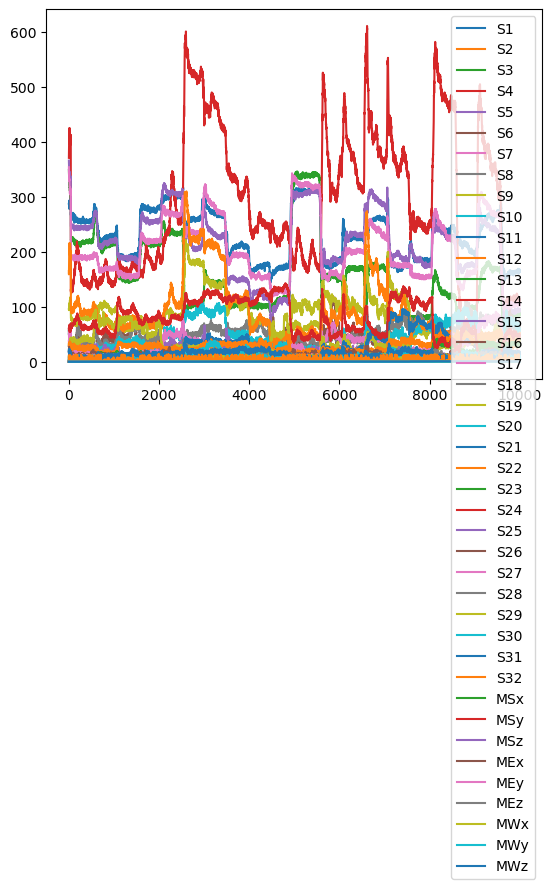

In [4]:
data.plot()

In [8]:
import yaml

with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [9]:
from types import SimpleNamespace

config =SimpleNamespace(**config)

In [28]:

locations = data[[
       'MCx','MCy', 'MCz','MSx', 'MSy', 'MSz',
       'MEx', 'MEy', 'MEz',
       'MWx', 'MWy', 'MWz'
       ]]

In [12]:

from utils import R_matrix


In [47]:
len(locations)

19999

In [31]:
MS = locations[['MSx', 'MSy', 'MSz']]
ME = locations[['MEx', 'MEy', 'MEz']]
MW = locations[['MWx', 'MWy', 'MWz']]

In [33]:
VStoE = ME.to_numpy()- MS.to_numpy()

In [34]:
VStoE[0]

array([-0.01941217,  0.3033426 , -0.10252228])

In [36]:
R_matrix.Get_R([0,1,0],VStoE[0])

array([[ 0.99811784, -0.06051419, -0.00994033],
       [ 0.06051419,  0.9456196 ,  0.319596  ],
       [-0.00994033, -0.319596  ,  0.94750176]])

MovieWriter stderr:
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory



Line2D(_child0)
Line2D(_child0)
Line2D(_child0)
Line2D(_child0)


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-framerate', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'ani.gif']' returned non-zero exit status 127.

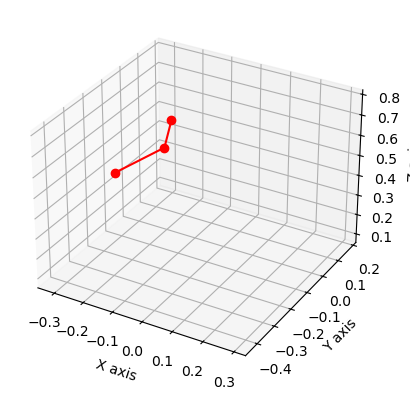

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
# Assuming 'df' is your DataFrame with the columns mentioned
# Example: df = pd.read_csv('your_data_file.csv')
df = locations
# Initialize plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Adjust these limits according to your data range
ax.set_xlim([df[['MSx', 'MEx', 'MWx']].min().min(), df[['MSx', 'MEx', 'MWx']].max().max()])
ax.set_ylim([df[['MSy', 'MEy', 'MWy']].min().min(), df[['MSy', 'MEy', 'MWy']].max().max()])
ax.set_zlim([df[['MSz', 'MEz', 'MWz']].min().min(), df[['MSz', 'MEz', 'MWz']].max().max()])

# Lines to connect points
line, = ax.plot([], [], [], 'ro-')

def update(frame):
    # Extract points for the current frame
    shoulder = (df.at[frame, 'MSx'], df.at[frame, 'MSy'], df.at[frame, 'MSz'])
    elbow = (df.at[frame, 'MEx'], df.at[frame, 'MEy'], df.at[frame, 'MEz'])
    wrist = (df.at[frame, 'MWx'], df.at[frame, 'MWy'], df.at[frame, 'MWz'])

    # Update line data
    line.set_data([shoulder[0], elbow[0], wrist[0]], [shoulder[1], elbow[1], wrist[1]])
    line.set_3d_properties([shoulder[2], elbow[2], wrist[2]])
    print(line)
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=range(len(df)), blit=True, repeat=True)
# ani.save('ani.gif')
plt.show()

In [13]:
from data.data_processing import DataProcessor
import yaml
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config = SimpleNamespace(**config)
data_processor = DataProcessor(config)
data_processor.load_data()
data_processor.preprocess_data()

train_loader, val_loader, test_loader = data_processor.get_data_loaders()
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print(f"Running on the CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("Running on CPU")
    return device

In [19]:
import torch
import torch.optim as optim
import torch.nn.functional as F
lr = 4e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
device = set_device()

def train(epoch,lr,loader,device):
    
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(epoch):
        for inputs, targets in train_loader:

            inputs = inputs.to(device=device)
            targets = targets.to(device=device)

            optimizer.zero_grad()
            output = model(inputs.permute(0,2,1))
            loss = F.mse_loss(output, targets)
            loss.backward()
            if 1 > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            batch_idx += 1
            total_loss += loss.item()

        # if batch_idx % 100 == 0:
        #     cur_loss = total_loss / args.log_interval
        #     processed = min(i+batch_size, X_train.size(0))
        #     print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
        #         epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
        #     total_loss = 0

Running on the CUDA device: NVIDIA GeForce RTX 3060 Ti


In [20]:
train(1,lr,train_loader,device)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same